In [1]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Random number generation
import random

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 
import seaborn as sns

# Deep learning
import tensorflow as tf 

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import losses

In [2]:
def create_X_Y_generalized(ts: np.array, n_features: int, lag=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag, target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [3]:
# Downloading data 
!python3 dataDownload.py

# Creating tidy data
!python3 createTidyData.py

Read municipality data in 0.36 seconds
Rows read: 13972
Read patient data in 0.82 seconds
Rows read: 36876
Data saved in data/2020-11-17


In [4]:
# Reading the data 
d = pd.read_csv('data/tidy_data.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the time series 
Yts = d.drop([
    'day', 
    'weekday_1', 
    'weekday_2',
    'weekday_3',
    'weekday_4',
    'weekday_5',
    'weekday_6',
    'weekday_7',
    'is_quarantine'
], axis=1)

# Adding a very small value 
eps = 0.0000001
Yts = Yts.apply(lambda x: x + eps)

# Getting the logs 
Yts = Yts.apply(np.log)

Yts = Yts.values

In [5]:
# Defining the lag 
n_lag = 14

# Number of features used in modeling
n_ft = Yts.shape[1]

# Creating the X and Y input for the LSTM model 
X, Y = create_X_Y_generalized(Yts, n_features=n_ft, lag=n_lag)

In [6]:
# Defining the last n days to use in validation
n_val = 3

# All indexes 
ind = list(range(len(X)))

# Getting the indexes for training 
train_idx = ind[:-n_val]

# Getting the indexes for validation 
val_idx = list(set(ind) - set(train_idx))

In [7]:
# Extracting train and validation matrices for deep learning training
Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xval, Yval = X[val_idx], Y[val_idx]

In [8]:
print(f'Full dataset shape: {X.shape}')

Full dataset shape: (238, 14, 209)


In [9]:
print(f"Shape of the training feature matrix: {Xtrain.shape}")

Shape of the training feature matrix: (235, 14, 209)


In [10]:
print(f"Shape of the validation feature matrix: {Xval.shape}")

Shape of the validation feature matrix: (3, 14, 209)


In [11]:
print(f"Shape of the target matrix: {Ytrain.shape}")

Shape of the target matrix: (235,)


In [12]:
print(f"Shape of the validation target matrix: {Yval.shape}")

Shape of the validation target matrix: (3,)


In [13]:
print(f"""
Values in validation target: {Yval} \n
Mean of validation values: {np.mean(Yval)}
""")


Values in validation target: [7.22402481 7.04751722 6.87316383] 

Mean of validation values: 7.0482352880396695



In [14]:
# Defining the hyper parameters for model training
n_layer = 4
batch = 16
epochs = 600
lr = 0.0001

In [15]:
# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, n_ft)))
model.add(Dense(1, use_bias=False))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 3424      
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 3,428
Trainable params: 3,428
Non-trainable params: 0
_________________________________________________________________


In [17]:
Xtrain.shape

(235, 14, 209)

In [18]:
# Initiating the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

# Fitting the model
history = model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch, validation_data=(Xval, Yval), shuffle=False)

Epoch 1/600
15/15 [==============================] - 0s 17ms/step - loss: 9.4638 - val_loss: 3.3911
Epoch 2/600
15/15 [==============================] - 0s 4ms/step - loss: 7.7626 - val_loss: 2.5320
Epoch 3/600
15/15 [==============================] - 0s 5ms/step - loss: 4.5324 - val_loss: 3.2472
Epoch 4/600
15/15 [==============================] - 0s 5ms/step - loss: 3.8003 - val_loss: 3.9215
Epoch 5/600
15/15 [==============================] - 0s 5ms/step - loss: 3.6896 - val_loss: 4.0971
Epoch 6/600
15/15 [==============================] - 0s 5ms/step - loss: 3.3081 - val_loss: 4.3742
Epoch 7/600
15/15 [==============================] - 0s 4ms/step - loss: 2.7571 - val_loss: 4.7263
Epoch 8/600
15/15 [==============================] - 0s 4ms/step - loss: 2.6183 - val_loss: 4.8890
Epoch 9/600
15/15 [==============================] - 0s 4ms/step - loss: 2.5883 - val_loss: 4.9477
Epoch 10/600
15/15 [==============================] - 0s 4ms/step - loss: 2.5768 - val_loss: 4.9757
Epoch 11

15/15 [==============================] - 0s 4ms/step - loss: 2.3226 - val_loss: 4.1479
Epoch 84/600
15/15 [==============================] - 0s 5ms/step - loss: 2.3216 - val_loss: 4.1198
Epoch 85/600
15/15 [==============================] - 0s 4ms/step - loss: 2.3154 - val_loss: 4.1929
Epoch 86/600
15/15 [==============================] - 0s 4ms/step - loss: 2.3119 - val_loss: 4.1612
Epoch 87/600
15/15 [==============================] - 0s 4ms/step - loss: 2.3103 - val_loss: 4.1308
Epoch 88/600
15/15 [==============================] - 0s 4ms/step - loss: 2.3048 - val_loss: 4.2012
Epoch 89/600
15/15 [==============================] - 0s 4ms/step - loss: 2.3008 - val_loss: 4.1653
Epoch 90/600
15/15 [==============================] - 0s 5ms/step - loss: 2.3012 - val_loss: 4.1547
Epoch 91/600
15/15 [==============================] - 0s 5ms/step - loss: 2.2993 - val_loss: 4.2711
Epoch 92/600
15/15 [==============================] - 0s 6ms/step - loss: 2.2928 - val_loss: 4.1997
Epoch 93/600


15/15 [==============================] - 0s 5ms/step - loss: 2.0774 - val_loss: 4.6745
Epoch 165/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0774 - val_loss: 4.6773
Epoch 166/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0822 - val_loss: 4.6486
Epoch 167/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0697 - val_loss: 4.6946
Epoch 168/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0739 - val_loss: 4.6845
Epoch 169/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0662 - val_loss: 4.7320
Epoch 170/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0653 - val_loss: 4.7476
Epoch 171/600
15/15 [==============================] - 0s 4ms/step - loss: 2.0704 - val_loss: 4.7225
Epoch 172/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0573 - val_loss: 4.7592
Epoch 173/600
15/15 [==============================] - 0s 5ms/step - loss: 2.0707 - val_loss: 4.7480
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 1.8841 - val_loss: 4.8943
Epoch 246/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8847 - val_loss: 4.8913
Epoch 247/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8872 - val_loss: 4.9561
Epoch 248/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8787 - val_loss: 4.9006
Epoch 249/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8773 - val_loss: 4.9322
Epoch 250/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8899 - val_loss: 4.8762
Epoch 251/600
15/15 [==============================] - 0s 4ms/step - loss: 1.8933 - val_loss: 5.0434
Epoch 252/600
15/15 [==============================] - 0s 4ms/step - loss: 1.8684 - val_loss: 4.8446
Epoch 253/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8993 - val_loss: 4.8041
Epoch 254/600
15/15 [==============================] - 0s 5ms/step - loss: 1.8827 - val_loss: 5.0028
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 1.6508 - val_loss: 5.0201
Epoch 327/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6366 - val_loss: 4.9648
Epoch 328/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6472 - val_loss: 5.0591
Epoch 329/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6289 - val_loss: 4.9132
Epoch 330/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6280 - val_loss: 5.0046
Epoch 331/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6193 - val_loss: 4.9826
Epoch 332/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6165 - val_loss: 5.0161
Epoch 333/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6122 - val_loss: 4.9976
Epoch 334/600
15/15 [==============================] - 0s 4ms/step - loss: 1.6165 - val_loss: 5.0130
Epoch 335/600
15/15 [==============================] - 0s 5ms/step - loss: 1.6193 - val_loss: 5.0717
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 1.3203 - val_loss: 1.8987
Epoch 408/600
15/15 [==============================] - 0s 5ms/step - loss: 1.2396 - val_loss: 1.7227
Epoch 409/600
15/15 [==============================] - 0s 5ms/step - loss: 1.2212 - val_loss: 1.1399
Epoch 410/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1977 - val_loss: 0.6680
Epoch 411/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1726 - val_loss: 1.3990
Epoch 412/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1478 - val_loss: 2.9714
Epoch 413/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1384 - val_loss: 3.3022
Epoch 414/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1292 - val_loss: 3.1253
Epoch 415/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1339 - val_loss: 2.9691
Epoch 416/600
15/15 [==============================] - 0s 5ms/step - loss: 1.1199 - val_loss: 2.9092
Epoc

15/15 [==============================] - 0s 4ms/step - loss: 0.8686 - val_loss: 1.8812
Epoch 489/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8759 - val_loss: 1.0434
Epoch 490/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8705 - val_loss: 1.8225
Epoch 491/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8891 - val_loss: 0.9509
Epoch 492/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8839 - val_loss: 2.4188
Epoch 493/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8624 - val_loss: 1.4656
Epoch 494/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8622 - val_loss: 1.9826
Epoch 495/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8832 - val_loss: 0.8373
Epoch 496/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8646 - val_loss: 1.9526
Epoch 497/600
15/15 [==============================] - 0s 5ms/step - loss: 0.8679 - val_loss: 1.0397
Epoc

15/15 [==============================] - 0s 4ms/step - loss: 0.7247 - val_loss: 0.6115
Epoch 570/600
15/15 [==============================] - 0s 5ms/step - loss: 0.6902 - val_loss: 1.5308
Epoch 571/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6852 - val_loss: 1.5005
Epoch 572/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6817 - val_loss: 1.4311
Epoch 573/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6781 - val_loss: 1.3439
Epoch 574/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6745 - val_loss: 1.2311
Epoch 575/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6697 - val_loss: 1.1273
Epoch 576/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6668 - val_loss: 1.0790
Epoch 577/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6639 - val_loss: 1.0423
Epoch 578/600
15/15 [==============================] - 0s 4ms/step - loss: 0.6610 - val_loss: 1.0029
Epoc

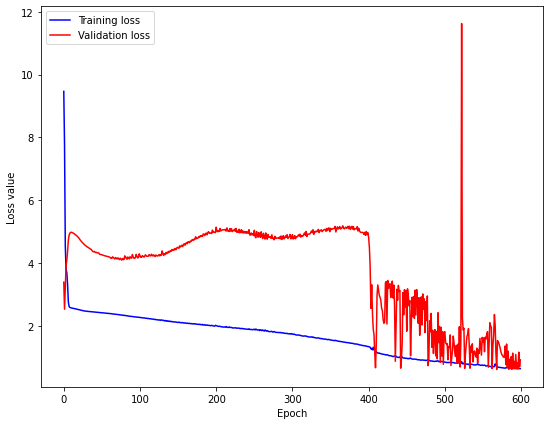

In [19]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [20]:
# Creating the final model 
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, n_ft)))
model.add(Dense(1))

# Initiating the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

# Fitting the model
history = model.fit(X, Y, epochs=epochs, batch_size=batch, shuffle=False)

Epoch 1/600
15/15 [==============================] - 0s 4ms/step - loss: 7.9791
Epoch 2/600
15/15 [==============================] - 0s 4ms/step - loss: 3.5999
Epoch 3/600
15/15 [==============================] - 0s 3ms/step - loss: 2.7804
Epoch 4/600
15/15 [==============================] - 0s 3ms/step - loss: 2.7344
Epoch 5/600
15/15 [==============================] - 0s 3ms/step - loss: 2.7013
Epoch 6/600
15/15 [==============================] - 0s 4ms/step - loss: 2.6721
Epoch 7/600
15/15 [==============================] - 0s 4ms/step - loss: 2.6123
Epoch 8/600
15/15 [==============================] - 0s 4ms/step - loss: 2.5712
Epoch 9/600
15/15 [==============================] - 0s 3ms/step - loss: 2.5565
Epoch 10/600
15/15 [==============================] - 0s 3ms/step - loss: 2.5120
Epoch 11/600
15/15 [==============================] - 0s 3ms/step - loss: 2.4894
Epoch 12/600
15/15 [==============================] - 0s 3ms/step - loss: 2.4708
Epoch 13/600
15/15 [=================

15/15 [==============================] - 0s 3ms/step - loss: 0.8281
Epoch 103/600
15/15 [==============================] - 0s 3ms/step - loss: 0.8260
Epoch 104/600
15/15 [==============================] - 0s 3ms/step - loss: 0.8327
Epoch 105/600
15/15 [==============================] - 0s 3ms/step - loss: 0.8198
Epoch 106/600
15/15 [==============================] - 0s 3ms/step - loss: 0.8129
Epoch 107/600
15/15 [==============================] - 0s 3ms/step - loss: 0.8073
Epoch 108/600
15/15 [==============================] - 0s 3ms/step - loss: 0.8026
Epoch 109/600
15/15 [==============================] - 0s 3ms/step - loss: 0.7971
Epoch 110/600
15/15 [==============================] - 0s 3ms/step - loss: 0.7927
Epoch 111/600
15/15 [==============================] - 0s 3ms/step - loss: 0.7888
Epoch 112/600
15/15 [==============================] - 0s 3ms/step - loss: 0.7871
Epoch 113/600
15/15 [==============================] - 0s 3ms/step - loss: 0.7980
Epoch 114/600
15/15 [=========

15/15 [==============================] - 0s 3ms/step - loss: 0.6233
Epoch 203/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6224
Epoch 204/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6219
Epoch 205/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6188
Epoch 206/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6230
Epoch 207/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6179
Epoch 208/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6204
Epoch 209/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6127
Epoch 210/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6139
Epoch 211/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6114
Epoch 212/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6105
Epoch 213/600
15/15 [==============================] - 0s 3ms/step - loss: 0.6140
Epoch 214/600
15/15 [=========

15/15 [==============================] - 0s 4ms/step - loss: 0.5357
Epoch 303/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5424
Epoch 304/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5422
Epoch 305/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5355
Epoch 306/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5361
Epoch 307/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5259
Epoch 308/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5280
Epoch 309/600
15/15 [==============================] - 0s 3ms/step - loss: 0.5360
Epoch 310/600
15/15 [==============================] - 0s 3ms/step - loss: 0.5321
Epoch 311/600
15/15 [==============================] - 0s 3ms/step - loss: 0.5341
Epoch 312/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5300
Epoch 313/600
15/15 [==============================] - 0s 4ms/step - loss: 0.5298
Epoch 314/600
15/15 [=========

15/15 [==============================] - 0s 4ms/step - loss: 0.4772
Epoch 403/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 404/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4794
Epoch 405/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4827
Epoch 406/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4920
Epoch 407/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4784
Epoch 408/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4843
Epoch 409/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4848
Epoch 410/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4988
Epoch 411/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4867
Epoch 412/600
15/15 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 413/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4859
Epoch 414/600
15/15 [=========

15/15 [==============================] - 0s 4ms/step - loss: 0.4522
Epoch 503/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4587
Epoch 504/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4572
Epoch 505/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4390
Epoch 506/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4388
Epoch 507/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4423
Epoch 508/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4583
Epoch 509/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4476
Epoch 510/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4419
Epoch 511/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4489
Epoch 512/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4464
Epoch 513/600
15/15 [==============================] - 0s 4ms/step - loss: 0.4603
Epoch 514/600
15/15 [=========

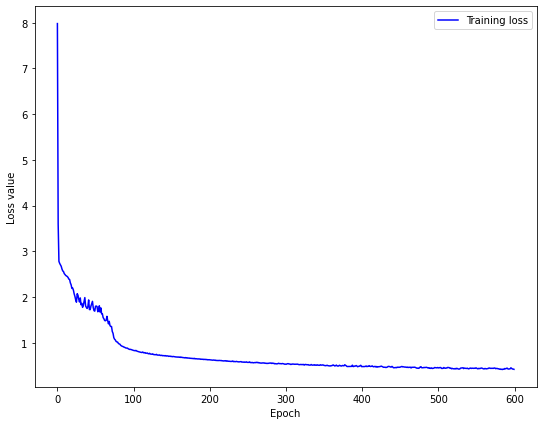

In [21]:
mse = history.history.get('loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [22]:
# Getting the newest data 
Ynew = Yts[-n_lag:]

# Reshaping for the model input 
Ynew = np.reshape(Ynew, (1, n_lag, n_ft))

print(f'Shape of the input for prediction: {Ynew.shape}')

Shape of the input for prediction: (1, 14, 209)


In [23]:
yhat = model.predict(Ynew)[0]
print(f'Prediction: {np.exp(yhat[0])}')

Prediction: 624.2688598632812


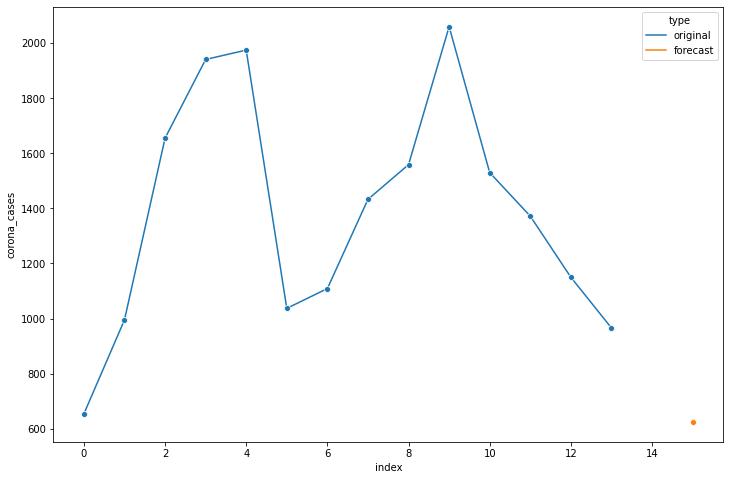

In [24]:
# Visualizing the prediction 
dorig = pd.DataFrame({
    'index': range(n_lag), 'corona_cases': [np.exp(x) for x in Y[-n_lag:]],
    'type': 'original'
})
dfc = pd.DataFrame({'index': n_lag + 1, 'corona_cases': np.exp(yhat[0]), 'type': 'forecast'}, index=[0])

dplot = pd.concat([dorig, dfc], axis=0)
plt.figure(figsize=(12, 8))
sns.lineplot(x='index', y='corona_cases', data=dplot, hue='type', marker='o')
plt.show()